Here we try to investigate whether the stock price movement of a particular day depends on the sentiment scores for the previous day (The sentiment scores were calculated using VADER and then for a given day, we considered the average score among all the news articled realeased that day about a given ticker)

We start our discussion with APPLE

In [76]:
import pandas as pd
import numpy as np
import datetime
from seaborn import set_style
import plotly as py

set_style("whitegrid")

In [77]:
Ap = pd.read_csv('..\Stock_data\Apple_stock.csv')

In [78]:
Ap.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-03-01 00:00:00-05:00,41.887973,42.097075,41.553888,42.053814,103544800,0.0,0.0
1,2019-03-04 00:00:00-05:00,42.226871,42.721989,41.813471,42.265327,109744800,0.0,0.0
2,2019-03-05 00:00:00-05:00,42.286956,42.301376,41.950465,42.188412,78949600,0.0,0.0
3,2019-03-06 00:00:00-05:00,41.981718,42.178806,41.806265,41.945667,83241600,0.0,0.0
4,2019-03-07 00:00:00-05:00,41.789428,41.926429,41.344785,41.460152,99185600,0.0,0.0


Visualizing the CLOSING PRICE over the DATE for the span of 2019/03 - 2024/03

In [79]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=Ap['Date'], y=Ap['Close'])])
fig.show()

Let's zoom in

Visualizing the CLOSING PRICE over the DATE for the year of 2023/03 - 2024/03

In [80]:
import plotly.express as px

Ap_2023 = Ap.loc[(Ap["Date"] >= "2023-03-01")]

fig = px.line(Ap_2023, x='Date', y='Close')
fig.update_xaxes(ticks= "outside",
                 ticklabelmode= "period", 
                 tickcolor= "black", 
                 ticklen=10, 
                 minor=dict(
                     ticklen=4,  
                     dtick=7*24*60*60*1000,  
                     tick0="2023-03-01", 
                     griddash='dot', 
                     gridcolor='white')
                )

fig.show()

It's hard to detect any local trends or seasonality from this visualization. We will put off the pattern detection of this time series alone to a different notebook. Here, we will focus on conducting an initial investigation of whether rising and falling of the stock price in a given day seem dependent on the total sentiment score of the day before. 

First, we will visualize the sentiment scores as well.

Then, we will devise a (somewhat naive) strategy for detecting a relationship between stock price movement and sentiment.

In [81]:
ApM = pd.read_csv('..\data\data_merged.csv')

In [82]:
ApM.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume
0,0,2019-03-15,MSFT,Technology,0.065,0.065,0.065,0.065,109.594,111.408,108.881,110.135,54681100.0
1,1,2019-03-18,MSFT,Technology,0.000,0.000,0.000,0.000,110.382,111.750,110.268,111.712,31207600.0
2,2,2019-03-26,MSFT,Technology,0.000,0.000,0.000,0.000,112.710,112.796,111.028,112.036,26097700.0
3,3,2019-03-28,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0
4,4,2019-03-31,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0


Visualizing the COMPOUND SENTIMENT SCORE over the DATE for the span of 2019/03 - 2024/03

In [83]:
ApM = ApM.loc[(ApM["Ticker"] == "AAPL")]
ApM_2023 = ApM.loc[(ApM["Date"] >= "2023-03-01")] 

fig = px.line(ApM_2023, x='Date', y='sentiment_tot')
fig.update_traces(line_color='purple')
fig.update_xaxes(ticks= "outside",
                 ticklabelmode= "period", 
                 tickcolor= "black", 
                 ticklen=10, 
                 minor=dict(
                     ticklen=4,  
                     dtick=7*24*60*60*1000,  
                     tick0="2023-03-01", 
                     griddash='dot', 
                     gridcolor='white')
                )

fig.show()

Let's zoom in
Visualizing the COMPOUND SENTIMENT SCORE over the DATE for the year of 2023/03 - 2024/03

In [84]:
#ApM = ApM.loc[(ApM["Ticker"] == "AAPL")]
ApM_2023 = ApM.loc[(ApM["Date"] >= "2023-03-01")] 

fig = px.line(ApM_2023, x='Date', y='sentiment_tot')
fig.update_traces(line_color='purple')
fig.update_xaxes(ticks= "outside",
                 ticklabelmode= "period", 
                 tickcolor= "black", 
                 ticklen=10, 
                 minor=dict(
                     ticklen=4,  
                     dtick=7*24*60*60*1000,  
                     tick0="2023-03-01", 
                     griddash='dot', 
                     gridcolor='white')
                )

fig.show()

Again, it is hard to detect patterns in this graph through such a large span of time. One strategy is to plot a few weeks' worth of data at a time, both sentiment scores & closing prices on the same figure. But to detect at how many places we find a possible relationships vs at how many places such relationships don't seem to exist, (regarding apple alone) we will have to plot many graphs to encompass the entire 5 years.

So we adopt the following strategy to get a rough estimate of how related the two data sets seem.

1. Create a column to record the daily rise
2. Create a column that records whether the price rises or falls during the day (by assigning 1 or -1 in each corresponding case, and 0 if there are no changes. Let's call this value "up or down".)
3. Create the following function that hopefully captures the "significantly related" entries


comparison_function ( up or down , sentiment score ) = 
1 
in the following cases:
(i.) up or down = 1 and sentiment score >= 0.1
(ii.) up or down = -1 and sentiment score <= -0.1
(STOCK AND SENTIMENT "AGREE")

comparison_function ( up or down , sentiment score ) = 
-1 
in the following cases:
(iii.) up or down = 1 and sentiment score <= -0.1
(iv.) up or down = -1 and sentiment score >= 0.1
(STOCK AND SENTIMENT "DISAGREE")

comparison_function ( up or down , sentiment score ) = 
0
(v.) Otherwise 

In [85]:
#creating a new column for closing price - opening price
ApM = ApM.assign(daily_rise = ApM.Close - ApM.Open)

In [86]:
#creating a function to check whether the price rises or falls
def rise_or_fall(i):
    if i > 0:
        return 1
    if i < 0:
        return -1
    else:
        return 0

In [87]:
#creating a new column to record whether the price rises or falls
ApM["up_or_down"] = ApM["daily_rise"].apply(rise_or_fall)

In [88]:
#Seeing how  the rise and fall would look
ApM = ApM.loc[(ApM["Ticker"] == "AAPL")]
ApM_23_08 = ApM.loc[(ApM["Date"] >= "2023-08-01")] 

fig = px.scatter(ApM_23_08, x='Date', y='up_or_down')
#fig.update_traces(line_color='purple')
fig.update_xaxes(ticks= "outside",
                 ticklabelmode= "period", 
                 tickcolor= "black", 
                 ticklen=10, 
                 minor=dict(
                     ticklen=4,  
                     dtick=7*24*60*60*1000,  
                     tick0="2023-03-01", 
                     griddash='dot', 
                     gridcolor='white')
                )

fig.show()

Wow, that's not helpful at all. But let's see how the rest of our plan plays out

Note that we need to compare yesterday's sentiment to today's stock movement

In [89]:
#here we are creating a column to record yesterday's total sentiment

#create the column "shifted_sent_tot" and record sentiment_tot shifted 1 row down
ApM['shifted_sent_tot'] = ApM['sentiment_tot'].shift(1)


In [90]:
ApM.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,daily_rise,up_or_down,shifted_sent_tot
1364,1364,2019-03-15,AAPL,Technology,0.00000,0.00000,0.00000,0.00000,44.428,45.025,44.162,44.734,156171600.0,0.306,1,NaN
1365,1365,2019-03-18,AAPL,Technology,0.02513,0.02513,0.02513,0.02513,44.657,45.279,44.654,45.190,104879200.0,0.533,1,0.00000
1366,1366,2019-03-19,AAPL,Technology,0.03990,0.03990,0.03990,0.03990,45.270,45.424,44.686,44.832,126585600.0,-0.438,-1,0.02513
1367,1367,2019-03-20,AAPL,Technology,0.03500,0.03500,0.03500,0.03500,44.760,45.544,44.400,45.224,124140800.0,0.464,1,0.03990
1368,1368,2019-03-21,AAPL,Technology,0.03433,0.03433,0.03433,0.03433,45.671,47.188,45.621,46.890,204136800.0,1.219,1,0.03500


In [91]:
#that top row is no good. let's get rid of it
ApM = ApM.loc[(ApM["Date"] >= "2019-03-18")] 
ApM.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,daily_rise,up_or_down,shifted_sent_tot
1365,1365,2019-03-18,AAPL,Technology,0.02513,0.02513,0.02513,0.02513,44.657,45.279,44.654,45.190,104879200.0,0.533,1,0.00000
1366,1366,2019-03-19,AAPL,Technology,0.03990,0.03990,0.03990,0.03990,45.270,45.424,44.686,44.832,126585600.0,-0.438,-1,0.02513
1367,1367,2019-03-20,AAPL,Technology,0.03500,0.03500,0.03500,0.03500,44.760,45.544,44.400,45.224,124140800.0,0.464,1,0.03990
1368,1368,2019-03-21,AAPL,Technology,0.03433,0.03433,0.03433,0.03433,45.671,47.188,45.621,46.890,204136800.0,1.219,1,0.03500
1369,1369,2019-03-22,AAPL,Technology,0.03311,0.03311,0.03311,0.03311,46.950,47.515,45.854,45.919,169630800.0,-1.031,-1,0.03433


Here we define our comparison function


In [92]:
#creating a function that will (naively) campare yesterday's total sentiment to whether today's stock rises or falls
def compare(i,j):
    if i == 1 and j >= 0.1:
        return 1
    if i == -1 and j <= -0.1:
        return 1
    if i == 1 and j <= -0.1:
        return -1
    if i == -1 and j >= 0.1:
        return -1 
    else:
        return 0

In [93]:
#Create a column titled "comparison" to record the function values of compare(up_or_down, shifted_sent_tot)
ApM['comparison']= ApM.apply(lambda x: compare(x['up_or_down'],x['shifted_sent_tot']) ,axis=1)

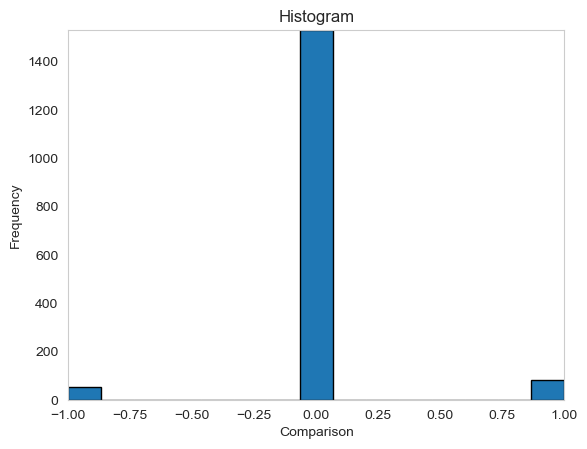

In [94]:
#Histogram for the comparison scores
ApM['comparison'].plot.hist(title='Histogram', xlabel='Comparison', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [95]:
ApM['comparison'].sum()

27

Here we used a margin of "-0.1 < total sentiment score < 0.1" as something that will correspond to compare function being 0.
We can test out a wider margin such as "-0.3 < total sentiment score < 0.3", but in this case the sum of the values in the comparison column ends up being 0. This is because the total sentiment scores for Apple don't venture too far from 0.


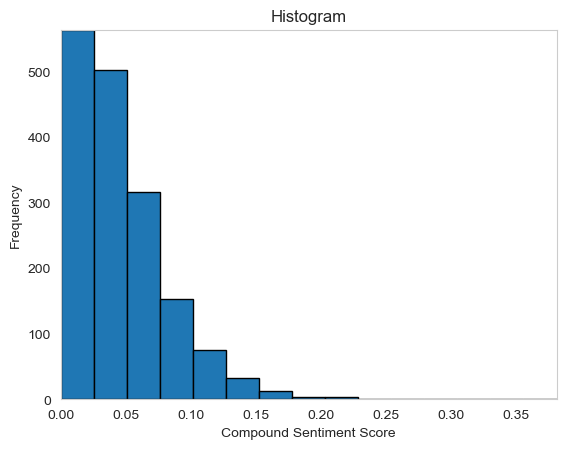

In [96]:
#Histogram for Total Sentiment Scores
ApM['sentiment_tot'].plot.hist(title='Histogram', xlabel='Compound Sentiment Score', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

Now let's take a similar look at other Tickers.


In [97]:
Data_merged = pd.read_csv('..\data\data_merged.csv')

In [98]:
Data_merged.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume
0,0,2019-03-15,MSFT,Technology,0.065,0.065,0.065,0.065,109.594,111.408,108.881,110.135,54681100.0
1,1,2019-03-18,MSFT,Technology,0.000,0.000,0.000,0.000,110.382,111.750,110.268,111.712,31207600.0
2,2,2019-03-26,MSFT,Technology,0.000,0.000,0.000,0.000,112.710,112.796,111.028,112.036,26097700.0
3,3,2019-03-28,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0
4,4,2019-03-31,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0


In [99]:
#Let's limit our dataframe to Microsoft
Msft = Data_merged.loc[(Data_merged["Ticker"] == "MSFT")]

In [100]:
#create the column "shifted_sent_tot" and record sentiment_tot shifted 1 row down
Msft['shifted_sent_tot'] = Msft['sentiment_tot'].shift(1)

#remove the top row
Msft = Msft.loc[(Msft["Date"] >= "2019-03-18")] 


C:\Users\kasun\AppData\Local\Temp\ipykernel_24252\758427491.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



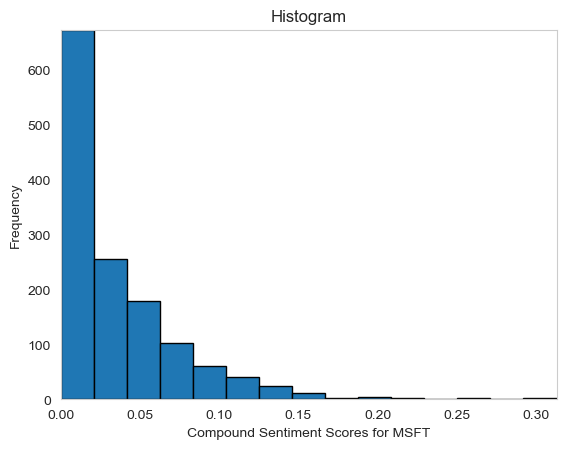

In [101]:
#Histogram for Total Sentiment Scores
Msft['sentiment_tot'].plot.hist(title='Histogram', xlabel='Compound Sentiment Scores for MSFT', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

Once again, it seems that the total sentiment scores mostly take values between 0 and 0.2

In [102]:
#create a new column for "closing price - opening price"
Msft = Msft.assign(daily_rise = Msft.Close - Msft.Open)

#create a new column to record whether the price rises or falls
Msft["up_or_down"] = Msft["daily_rise"].apply(rise_or_fall)

#Create a column titled "comparison" to record the function values of compare(up_or_down, shifted_sent_tot)
Msft['comparison']= Msft.apply(lambda x: compare(x['up_or_down'],x['shifted_sent_tot']) ,axis=1)

In [103]:
Msft.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,shifted_sent_tot,daily_rise,up_or_down,comparison
1,1,2019-03-18,MSFT,Technology,0.000,0.000,0.000,0.000,110.382,111.750,110.268,111.712,31207600.0,0.065,1.330,1,0
2,2,2019-03-26,MSFT,Technology,0.000,0.000,0.000,0.000,112.710,112.796,111.028,112.036,26097700.0,0.000,-0.674,-1,0
3,3,2019-03-28,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0,0.000,-0.485,-1,0
4,4,2019-03-31,MSFT,Technology,0.000,0.000,0.000,0.000,111.589,111.722,110.344,111.104,18334800.0,0.000,-0.485,-1,0
5,5,2019-04-02,MSFT,Technology,0.082,0.082,0.082,0.082,113.128,113.527,112.615,113.252,18142300.0,0.000,0.124,1,0


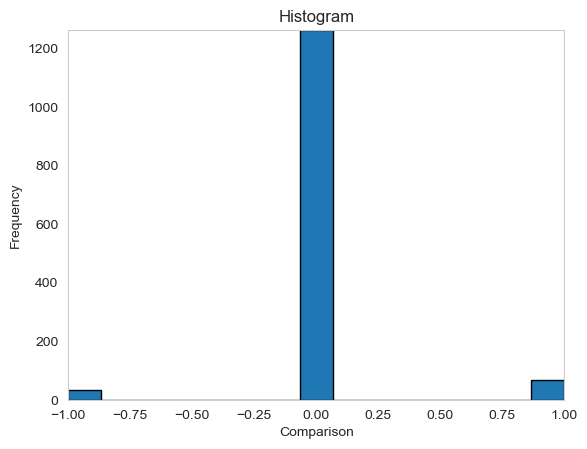

In [104]:
#Histogram for the comparison scores
Msft['comparison'].plot.hist(title='Histogram', xlabel='Comparison', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [105]:
Msft['comparison'].sum()

36

In [106]:
#Let's limit our dataframe to Amazon
Amz = Data_merged.loc[(Data_merged["Ticker"] == "AMZN")]

In [107]:
Amz.head()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume
5824,5824,2019-03-15,AMZN,Technology,0.00983,0.00983,0.00983,0.00983,85.150,85.940,84.656,85.618,151018000.0
5825,5825,2019-03-16,AMZN,Technology,0.03150,0.03150,0.03150,0.03150,85.150,85.940,84.656,85.618,151018000.0
5826,5826,2019-03-18,AMZN,Technology,0.03600,0.03600,0.03600,0.03600,85.635,87.500,85.632,87.108,108582000.0
5827,5827,2019-03-19,AMZN,Technology,0.06280,0.06280,0.06280,0.06280,87.675,89.208,87.675,88.093,127284000.0
5828,5828,2019-03-20,AMZN,Technology,0.02829,0.02829,0.02829,0.02829,88.497,89.975,88.352,89.864,125312000.0


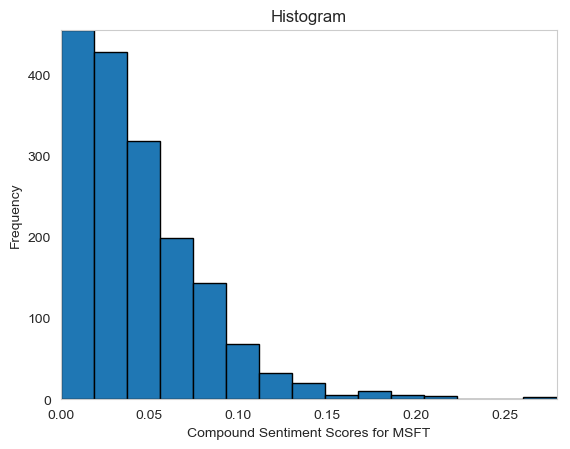

In [108]:
#Histogram for Total Sentiment Scores
Amz['sentiment_tot'].plot.hist(title='Histogram', xlabel='Compound Sentiment Scores for MSFT', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [109]:
#create the column "shifted_sent_tot" and record sentiment_tot shifted 1 row down
Amz['shifted_sent_tot'] = Amz['sentiment_tot'].shift(1)

#remove the top row
Amz = Amz.loc[(Amz["Date"] >= "2019-03-18")] 

C:\Users\kasun\AppData\Local\Temp\ipykernel_24252\2421960496.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
#create a new column for "closing price - opening price"
Amz = Amz.assign(daily_rise = Amz.Close - Amz.Open)

#create a new column to record whether the price rises or falls
Amz["up_or_down"] = Amz["daily_rise"].apply(rise_or_fall)

#Create a column titled "comparison" to record the function values of compare(up_or_down, shifted_sent_tot)
Amz['comparison']= Amz.apply(lambda x: compare(x['up_or_down'],x['shifted_sent_tot']) ,axis=1)

In [111]:
Amz.head()


,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,shifted_sent_tot,daily_rise,up_or_down,comparison
5826,5826,2019-03-18,AMZN,Technology,0.03600,0.03600,0.03600,0.03600,85.635,87.500,85.632,87.108,108582000.0,0.03150,1.473,1,0
5827,5827,2019-03-19,AMZN,Technology,0.06280,0.06280,0.06280,0.06280,87.675,89.208,87.675,88.093,127284000.0,0.03600,0.418,1,0
5828,5828,2019-03-20,AMZN,Technology,0.02829,0.02829,0.02829,0.02829,88.497,89.975,88.352,89.864,125312000.0,0.06280,1.367,1,0
5829,5829,2019-03-21,AMZN,Technology,0.11580,0.11580,0.11580,0.11580,89.813,91.188,89.364,90.963,115356000.0,0.02829,1.150,1,0
5830,5830,2019-03-22,AMZN,Technology,0.01800,0.01800,0.01800,0.01800,90.508,90.949,88.156,88.239,127260000.0,0.11580,-2.269,-1,-1


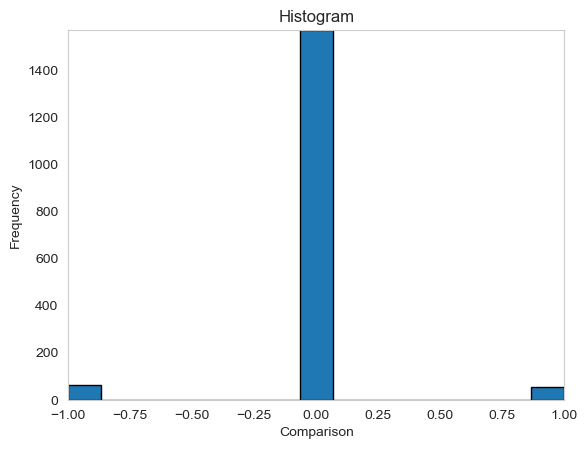

In [112]:
#Histogram for the comparison scores
Amz['comparison'].plot.hist(title='Histogram', xlabel='Comparison', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [113]:
Amz['comparison'].sum()

-7

GOOGLE

In [114]:
#Let's limit our dataframe to Google
Ggl = Data_merged.loc[(Data_merged["Ticker"] == "GOOGL")]

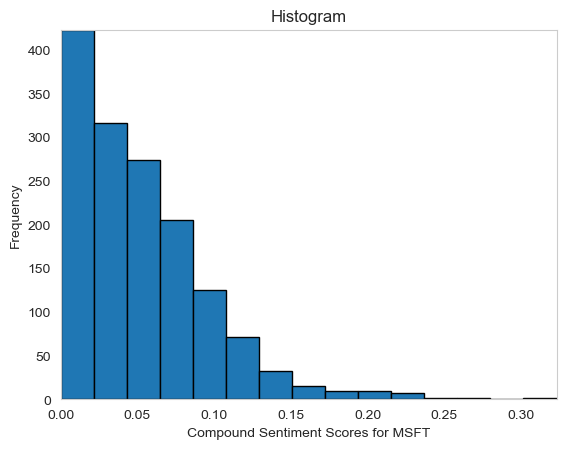

In [115]:
#Histogram for Total Sentiment Scores
Ggl['sentiment_tot'].plot.hist(title='Histogram', xlabel='Compound Sentiment Scores for MSFT', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [116]:
#create the column "shifted_sent_tot" and record sentiment_tot shifted 1 row down
Ggl['shifted_sent_tot'] = Ggl['sentiment_tot'].shift(1)



C:\Users\kasun\AppData\Local\Temp\ipykernel_24252\362505332.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
#remove the top row
Ggl = Ggl.loc[(Ggl["Date"] >= "2019-03-18")] 

In [118]:
#create a new column for "closing price - opening price"
Ggl = Ggl.assign(daily_rise = Ggl.Close - Ggl.Open)

#create a new column to record whether the price rises or falls
Ggl["up_or_down"] = Ggl["daily_rise"].apply(rise_or_fall)

#Create a column titled "comparison" to record the function values of compare(up_or_down, shifted_sent_tot)
Ggl['comparison']= Ggl.apply(lambda x: compare(x['up_or_down'],x['shifted_sent_tot']) ,axis=1)

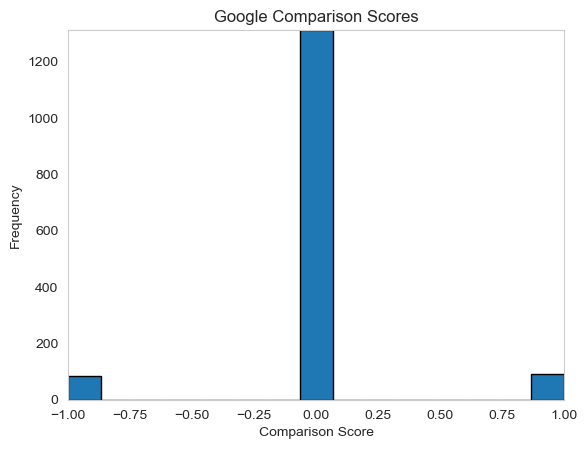

In [119]:
#Histogram for the comparison scores
Ggl['comparison'].plot.hist(title='Google Comparison Scores', xlabel='Comparison Score', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [120]:
Ggl['comparison'].sum()

8

NVIDIA

In [121]:
#Let's limit our dataframe to Nvidia
Nvd = Data_merged.loc[(Data_merged["Ticker"] == "NVDA")]

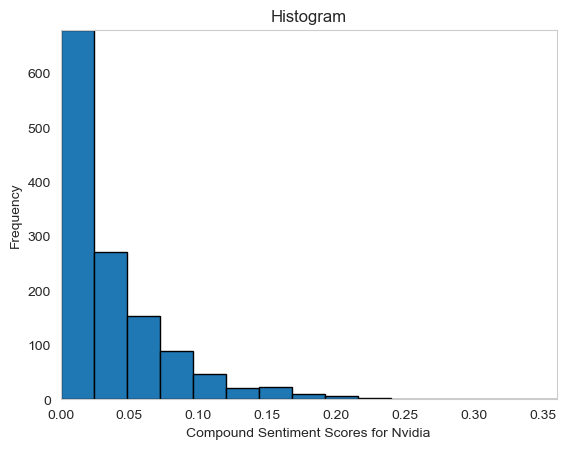

In [122]:
#Histogram for Total Sentiment Scores
Nvd['sentiment_tot'].plot.hist(title='Histogram', xlabel='Compound Sentiment Scores for Nvidia', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

(Question for later: Why are almost all compound scores in the tech sector seem to be stuck between 0 and 0.25 ? )

In [123]:
#create the column "shifted_sent_tot" and record sentiment_tot shifted 1 row down
Nvd['shifted_sent_tot'] = Nvd['sentiment_tot'].shift(1)


C:\Users\kasun\AppData\Local\Temp\ipykernel_24252\3326211776.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
#remove the top row
Nvd = Nvd.loc[(Nvd["Date"] >= "2019-03-18")] 

In [125]:
#create a new column for "closing price - opening price"
Nvd = Nvd.assign(daily_rise = Nvd.Close - Nvd.Open)

#create a new column to record whether the price rises or falls
Nvd["up_or_down"] = Nvd["daily_rise"].apply(rise_or_fall)

#Create a column titled "comparison" to record the function values of compare(up_or_down, shifted_sent_tot)
Nvd['comparison']= Nvd.apply(lambda x: compare(x['up_or_down'],x['shifted_sent_tot']) ,axis=1)

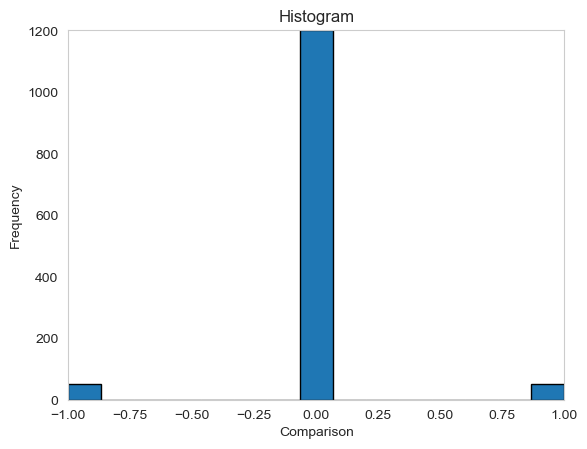

In [126]:
#Histogram for the comparison scores
Nvd['comparison'].plot.hist(title='Histogram', xlabel='Comparison', grid=False, bins=15, edgecolor='k').autoscale(enable=True, tight=True)

In [127]:
Nvd['comparison'].sum()

1

This seems like a razor thin margin. Let's take a closer look.

In [ ]:
Nvd.groupby(['comparison']).count()

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,shifted_sent_tot,daily_rise,up_or_down
comparison,,,,,,,,,,,,,,,,
-1,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
0,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1201,1202,1202
1,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


I'm going to double check that there are infact no instances where sentiment total is negative

In [135]:
Nvd_neg = Nvd.loc[Nvd["sentiment_tot"] < 0]

In [137]:
Nvd_neg.head(10)

,Unnamed: 0,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,Open,High,Low,Close,Volume,shifted_sent_tot,daily_rise,up_or_down,comparison


So it really seems that the displayed "agreement" or "disagreement" between stock movement and sentiment here only depended on positive sentment coinciding with instances of stock closing price rising or falling. We aee missing a key aspect of the news here, which is any news that actually may have been negatively percieved by the readers. 